#Problema 13 de la guía 9
##S. Schiavinato LU:153/1
###Test comparativo de distribuciones

In [2]:
%matplotlib inline
import numpy as np
import numpy.linalg as lin
import numpy.random as rnd
import scipy.misc as misc
import scipy.optimize as opt
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5 * (1 + np.sqrt(5)) / 2, 5)
plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["axes.labelsize"] = 20

χ2 = 66.26647034176688, p = 0.142050775060386
Dn = 0.0316087390617642, p = 0.002437846836559898


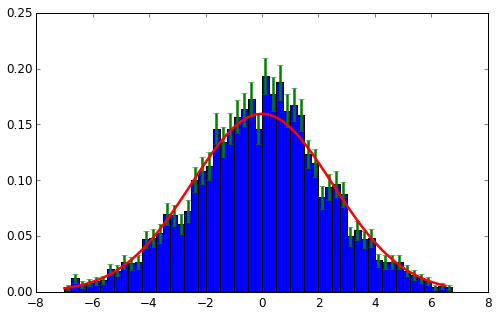

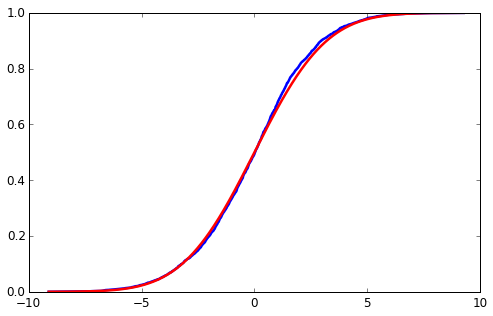

In [40]:
#Debe estar el archivo double_exp.dat en el mismo path que el ipynb
gauss = stats.norm(0, 2.5)
data = np.loadtxt("datos-G9E13.dat") 
bins = np.arange(-7,7,0.25)
data = data[:3000]
data.sort()
N = data.shape[0]
#plt.axhline(y = 10, c="k",ls="--")
hist, bins = np.histogram(data, bins = bins);
yerr = np.sqrt(hist)/(hist.sum()*np.diff(bins))
histNorm = hist/(hist.sum()*np.diff(bins))
plt.bar(bins[:-1], histNorm, ecolor = "g", yerr = yerr, width = np.diff(bins))
χ2 = 0
for i in range(bins[:-1].shape[0]):
    ni = hist[i]
    fi = N * (stats.norm(0,2.5).cdf(bins[i + 1]) - stats.norm(0,2.5).cdf(bins[i]))
    χ2 += (ni - fi)**2/ni
plt.figure(1)
plt.plot(bins[:-1], gauss.pdf(bins[:-1]), 'r-')
p = 1 - stats.chi2(bins[:-1].shape[0]).cdf(χ2)
print("χ2 = {}, p = {}".format(χ2, p))

#print(stats.kstest(hist, "norm"))
S = [[data[0], 0]]
for i in range(1, N):
        S.append([data[i], 1/N + S[-1][1]])
S = np.array(S)
plt.figure(2)
plt.plot(S[:,0], S[:,1])
plt.plot(S[:,0], gauss.cdf(S[:,0]), 'r-', label = "Gaussiana");
#plt.legend(loc = 0)
#print((ecdf-gauss.cdf(bins[:-1])).max())
D = np.abs(S[:,1] - gauss.cdf(S[:,0])).max()
pKS = 1 - stats.ksone(N).cdf(D)
print("Dn = {}, p = {}".format(D, pKS))